In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [2]:
ls

Obtaining Datasets/            my_functions_product1.py
README.md*                     product1_main.py*
__pycache__/                   step_by_step-7.ipynb
compass_data_first_look.ipynb  step_by_step-8.ipynb
data/                          step_by_step-9.ipynb


In [3]:
import my_functions_product1 as myFC

# reading the file from a path and list the field names and input columns of interest
path = 'data/adult.data'
#path = 'data/compas.csv'
#path = 'data/bank.csv'
X_df, Ybin, Zbin = myFC.read_process_data_output_bias(path)

Columns in your data are:
  ['39' ' State-gov' ' 77516' ' Bachelors' ' 13' ' Never-married'
 ' Adm-clerical' ' Not-in-family' ' White' ' Male' ' 2174' ' 0' ' 40'
 ' United-States' ' <=50K']
Your possible target columns '{' United-States', ' <=50K', ' White', ' State-gov', ' Never-married', ' 2174', ' 0', ' 77516', ' 40', ' Not-in-family', ' Adm-clerical', '39', ' Male', ' 13', ' Bachelors'}'
Which column is your target column?: <=50K
Your target column is ' <=50K'
Do you have any column for your current prediction? Please enter Y or N:N
Do you have any column for your current prediction? You entered'N'
Your prediction column possible values '{' >50K', ' <=50K'}'
Please enter two different labels in the target field: 
Enter label 0: <=50K
Your target label 0 is ' <=50K'
Enter label 1: >50K
Your target label 1 is ' >50K'
Your possible Sensitive Attribute columns '{' United-States', ' White', ' State-gov', ' Never-married', ' 2174', ' 0', ' 77516', ' 40', ' Not-in-family', ' Adm-clerical'

### Train test split

In [4]:
X = pd.get_dummies(X_df,drop_first=True) 
print(type(X),X.shape)
print(type(X_df),X_df.shape)

<class 'pandas.core.frame.DataFrame'> (32560, 100)
<class 'pandas.core.frame.DataFrame'> (32560, 14)


In [5]:
#X = pd.get_dummies(X_df,drop_first=True) 
Y = Ybin 
Z = Zbin
test_train_ratio = 0.5

#TODO: Can I do this in Keras?
# TODO : what should be left to the user

# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, test_size=test_train_ratio, 
                                                                     stratify=Y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

print(X_train.shape)
print(X_test.shape)

#X_train = np.array(X_train)
#X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(16280, 100)
(16280, 100)
(16280, 100)
(16280, 100)


### Your model

In [6]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    dense4 = Dense(32, activation="relu")(dropout3)
    dropout4 = Dropout(0.2)(dense4)
    outputs = Dense(1, activation='sigmoid')(dropout4)
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [7]:
main_task_arch = nn_classifier(n_features=X_train.shape[1])

main_task_arch_json_string = main_task_arch.to_json()


main_task_ori = model_from_json(main_task_arch_json_string)
# initialise NeuralNet Classifier

main_task_ori.compile(loss='binary_crossentropy', optimizer='adam')

In [8]:
# train on train set
history = main_task_ori.fit(X_train, y_train, epochs=20, verbose=0)

In [9]:
main_task_ori.predict(X_test).ravel().shape

(16280,)

In [10]:
# predict on test set
y_pred = main_task_ori.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1

In [11]:
def main_task_performance(X_test,y_test,y_hat):

    main_task_accuracy = accuracy_score(y_test, y_hat)
    return main_task_accuracy

In [12]:
main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = myFC.bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)

Accuracy: 85.27
p_rule_for_Y1 32.64


### Adding adversarial net

In [13]:
        
def adv_net_arch(inputs):
    dense1 = Dense(32, activation='relu')(inputs)
    dense2 = Dense(32, activation='relu')(dense1)
    dense3 = Dense(32, activation='relu')(dense2)
    dense4 = Dense(32, activation="relu")(dense3)
    outputs = Dense(1, activation='sigmoid')(dense4)# for _ in range(n_sensitive)]
    return Model(inputs=[inputs], outputs=outputs)
    
adv_inputs = Input(shape=(1,))
adv_task_arch = adv_net_arch(adv_inputs)

adv_task_arch_json_string = adv_task_arch.to_json()
    







In [14]:
# HIDE

class FairClassifier(object):
    
    def __init__(self, tradeoff_lambda,main_task_arch_json_string,adv_task_arch_json_string):
        self.tradeoff_lambda = tradeoff_lambda
        
        
        
        clf_net = self._create_clf_net(main_task_arch_json_string)
        adv_net = self._create_adv_net(adv_task_arch_json_string)
        
        clf_inputs = clf_net.input
        
        adv_inputs = adv_net.input

        
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    """def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        dense4 = Dense(32, activation="relu")(dropout3)
        dropout4 = Dropout(0.2)(dense4)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout4)
        return Model(inputs=[inputs], outputs=[outputs])"""
    
    def _create_clf_net(self, main_task_arch_json_string):
        architecture = model_from_json(main_task_arch_json_string)
        return(architecture)
        
    """def _create_adv_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        dense4 = Dense(32, activation="relu")(dense3)
        outputs = Dense(1, activation='sigmoid')(dense4)# for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)"""
    
    def _create_adv_net(self, adv_task_arch_json_string):
        architecture = model_from_json(adv_task_arch_json_string)
        return(architecture)    

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):

        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+[adv_net(clf_net(inputs))])
        
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-self.tradeoff_lambda]
        
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy'], optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        
        """
        balanced_weights = compute_class_weight('balanced', class_values, data_set)
        class_weights.append(dict(zip(class_values, balanced_weights)))
        
        """
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
              
                
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, z.values, class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False):
        
        
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = [] #pd.DataFrame()  
        
        for idx in range(T_iter):
            print(idx)
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                
               
                self._fairness_metrics.append(myFC.bias_checker_p_rule_bin((y_pred>0.5)*1.0,z_val))
                
                display.clear_output(wait=True)

            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, z.values, batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            #self._clf_w_adv.train_on_batch(x.values[indices], 
                                           #[y.values[indices]]+[z.values[indices]])
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+[z.values[indices]],
                                           class_weight=class_weight_clf_w_adv)

In [15]:
tradeoff_lambda = 100.

#lambda_race=130
#lambda_sex=30
# initialise FairClassifier
clf = FairClassifier(tradeoff_lambda=tradeoff_lambda,
                     main_task_arch_json_string=main_task_arch_json_string,
                     adv_task_arch_json_string=adv_task_arch_json_string)


### Pre train and its results

In [16]:
#print(bu0)
# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

In [17]:

# predict on test set
y_pred = clf.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1


main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = myFC.bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)



Accuracy: 84.94
p_rule_for_Y1 29.17


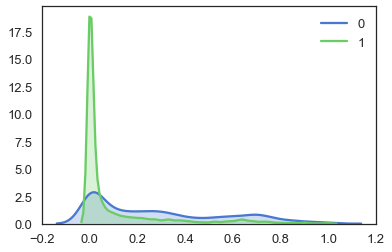

In [18]:
ax = sns.distplot(y_pred[Z_test == 0], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('0'))
ax = sns.distplot(y_pred[Z_test == 1], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('1'))

### Adversarial train and its resuls

In [19]:
# adverserial train on train set and validate on test set
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=165, save_figs=create_gif)

164


In [20]:
# predict on test set
y_pred = clf.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1


main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = myFC.bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)


Accuracy: 81.29
p_rule_for_Y1 98.86


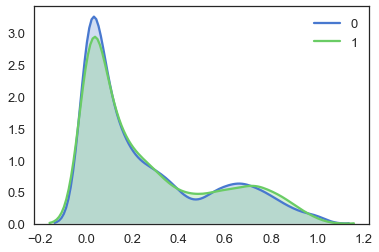

In [21]:
ax = sns.distplot(y_pred[Z_test == 0], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('0'))
ax = sns.distplot(y_pred[Z_test == 1], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('1'))

In [22]:
pwd

'/Users/bursaliogluozgun/Desktop/INSIGHT/My project/My Folder/Insight-fairness-in-data-ml/Product1'

In [ ]:
ls